#### GPU / CPU Device

In [47]:
import torch


device = torch.device('cpu')

if torch.cuda.is_available():

    device = torch.device('cuda')

#### Data Preprocessing

In [48]:
import torchvision


class SquashTransform:

    def __call__(self, inputs):
        return 2 * inputs - 1


data_train = torchvision.datasets.ImageFolder(
    'mini-birds',
    transform=torchvision.transforms.Compose([
#         torchvision.transforms.Resize((64, 64)),
        torchvision.transforms.ToTensor(),
        SquashTransform()
    ])
)

In [49]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

num_steps =  int(600 // BATCH_SIZE)

num_steps

18

#### Global Dimensions

In [50]:
# Number of channels in the training images.
# For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Size of labels dimension
nl = 10

#### Generator Design

Reference: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [51]:
class Generator(torch.nn.Module):

    def __init__(self):

        super(Generator, self).__init__()

        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(
                in_channels=nz + nl,
                out_channels=ngf * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 8
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 8,
                out_channels=ngf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 4
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 4,
                out_channels=ngf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf * 2
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(
                in_channels=ngf * 2,
                out_channels=ngf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ngf
            ),
            torch.nn.ReLU(
                inplace=True
            ),

            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(
                in_channels=ngf,
                out_channels=nc,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, inputs, condition):
        # Concatenate Noise and Condition
        cat_inputs = torch.cat(
            (inputs, condition),
            dim=1
        )
        
        # Reshape the latent vector into a feature map.
        cat_inputs = cat_inputs.unsqueeze(2).unsqueeze(3)

        return self.main(cat_inputs)

#### Discriminator Design

In [52]:
class Discriminator(torch.nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(
                in_channels=nc,
                out_channels=ndf,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(
                in_channels=ndf,
                out_channels=ndf * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 2
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(
                in_channels=ndf * 2,
                out_channels=ndf * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 4
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            ),

            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(
                in_channels=ndf * 4,
                out_channels=ndf * 8,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False
            ),
            torch.nn.BatchNorm2d(
                num_features=ndf * 8
            ),
            torch.nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
        
        # Categorical Classifier
        self.clf = torch.nn.Sequential(
            torch.nn.Linear(
                in_features=ndf * 8 * 4 * 4,
                out_features=nl,
                bias=True
            ),
            torch.nn.Softmax(dim=1)
        )
        
        # Real / Fake Classifier
        self.police = torch.nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(
                in_channels=ndf * 8,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False
            ),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        features = self.main(input)
        valid = self.police(features).view(-1, 1)
        clf = self.clf(features.view(features.shape[0], -1))
        return valid, clf

#### Weight Initialization

In [53]:
# custom weights initialization called on netG and netD
def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
netD = Discriminator().to(device)
netG = Generator().to(device)

netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(110, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#### Optimizer

In [54]:
# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(
    netD.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

optimizerG = torch.optim.Adam(
    netG.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

In [55]:
fixed_noise = torch.randn(
    nl, nz
).to(device)


real_labels = torch.ones(BATCH_SIZE, 1).to(device)
fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

c1 = torch.nn.BCELoss()
# c2 = torch.nn.CrossEntropyLoss()

#### Categorical Cross-Entropy

In [56]:
def c2(input, target):

    _, labels = target.max(dim=1)

    return torch.nn.CrossEntropyLoss()(input, labels)

#### One Hot Encoding

In [57]:
def encodeOneHot(labels):
    ret = torch.FloatTensor(labels.shape[0], nl)
    ret.zero_()
    ret.scatter_(dim=1, index=labels.view(-1, 1), value=1)
    return ret



fixed_conditions = encodeOneHot(
    torch.randint(
        0,
        nl,
        (nl, 1)
    )
).to(device)

#### Train Discriminator

In [58]:
def trainD(images, labels):

    real_images = images.to(device)
    real_conditions = encodeOneHot(labels).to(device)

    fake_conditions = encodeOneHot(
        torch.randint(
            0,
            nl,
            (BATCH_SIZE, 1)
        )
    ).to(device)

    fake_images = netG(
        torch.randn(
            BATCH_SIZE, nz
        ).to(device),
        fake_conditions  
    )

    optimizerD.zero_grad()

    real_valid, real_clf = netD(real_images)
    fake_valid, fake_clf = netD(fake_images)

    l_s = c1(
        real_valid, real_labels
    ) + c1(
        fake_valid, fake_labels
    )

    l_c = c2(
        real_clf, real_conditions
    ) + c2(
        fake_clf, fake_conditions
    )

    d_loss = l_s + l_c

    d_loss.backward()

    optimizerD.step()

    return d_loss


#### Train Generator

In [59]:
def trainG(labels):
        
    conditions = encodeOneHot(labels).to(device)

    z = torch.randn(
        BATCH_SIZE, nz
    ).to(device)

    netG.zero_grad()

    valid_outputs, clf_outputs = netD(
        netG(
            z,
            conditions
        )
    )

    ls = c1(valid_outputs, real_labels)
    lc = c2(clf_outputs, conditions)

    loss = lc + ls

    loss.backward()

    optimizerG.step()

    return loss

#### Tensorboard

In [60]:
# https://pytorch.org/docs/stable/tensorboard.html
from torch.utils.tensorboard import SummaryWriter


# Writer will output to ./runs/ directory by default
tb_writer = SummaryWriter()

#### Restore Checkpoint

In [61]:
import os


if os.path.exists('./sec_4_lec_4_netG.pytorch'):

    netG.load_state_dict(torch.load('./sec_4_lec_4_netG.pytorch'))

if os.path.exists('./sec_4_lec_4_netD.pytorch'):

    netD.load_state_dict(torch.load('./sec_4_lec_4_netD.pytorch'))

if os.path.exists('./sec_4_lec_4_optG.pytorch'):

    optimizerG.load_state_dict(torch.load('./sec_4_lec_4_optG.pytorch'))

if os.path.exists('./sec_4_lec_4_optD.pytorch'):

    optimizerD.load_state_dict(torch.load('./sec_4_lec_4_optD.pytorch'))

#### Train Network

In [ ]:
for epoch in range(2001):

    d_loss = 0
    g_loss = 0
    
    for i, (images, labels) in enumerate(train_loader):

        if i == num_steps:
            break

        for k in range(1):

             d_loss += trainD(images, labels)

        g_loss = trainG(labels)

    
    if epoch % 100 == 0:
        print(
            "E:{}, G Loss:{}, D Loss:{}".format(
                epoch,
                g_loss / num_steps,
                d_loss / num_steps / 1
            )
        )

        # Tensorboards Logging
        tb_writer.add_scalar(
            'DCGAN/D Loss',
            d_loss / num_steps / 1,
            epoch
        )

        tb_writer.add_scalar(
            'DCGAN/G Loss',
            g_loss / num_steps,
            epoch
        )

        generated = netG(
            fixed_noise,
            fixed_conditions
        ).detach().cpu().view(
            -1,
            3,
            64,
            64
        )

        grid = torchvision.utils.make_grid(
            generated,
            nrow=5,
            padding=10,
            pad_value=1,
            normalize=True
        )

        tb_writer.add_image(
            'DCGAN/Output',
            grid,
            epoch
        )
        
        
        # Save checkpoint
        torch.save(netG.state_dict(), './sec_4_lec_4_netG.pytorch')
        torch.save(netD.state_dict(), './sec_4_lec_4_netD.pytorch')
        torch.save(optimizerG.state_dict(), './sec_4_lec_4_optG.pytorch')
        torch.save(optimizerD.state_dict(), './sec_4_lec_4_optD.pytorch')

E:0, G Loss:0.5942848324775696, D Loss:3.0144970417022705
E:100, G Loss:0.6293113231658936, D Loss:3.031587839126587
E:200, G Loss:1.786165714263916, D Loss:2.9832236766815186
E:300, G Loss:3.2723782062530518, D Loss:2.9375698566436768
E:400, G Loss:0.6991131901741028, D Loss:3.1957666873931885
E:500, G Loss:0.8765804767608643, D Loss:3.045153856277466
E:600, G Loss:0.6306699514389038, D Loss:2.9694972038269043
E:700, G Loss:0.6850957274436951, D Loss:2.992051124572754
E:800, G Loss:3.4162137508392334, D Loss:2.93430757522583
E:900, G Loss:0.4747140109539032, D Loss:3.0062522888183594
E:1000, G Loss:0.45721906423568726, D Loss:2.983222007751465
E:1100, G Loss:0.526709794998169, D Loss:2.962838888168335
E:1200, G Loss:2.779221773147583, D Loss:2.934220552444458
E:1300, G Loss:2.705744981765747, D Loss:2.952286720275879
E:1400, G Loss:2.670408248901367, D Loss:2.9326062202453613


#### Visualize Result

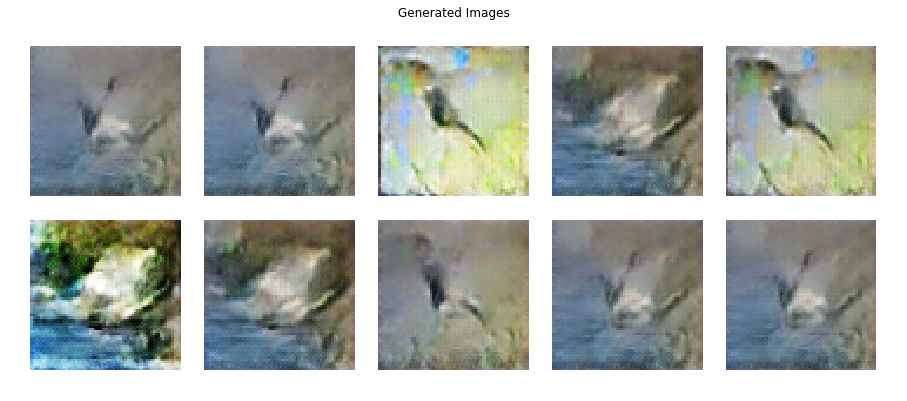

In [68]:
from matplotlib import pyplot as plt 
import numpy as np

%matplotlib inline

generated = netG(fixed_noise, fixed_conditions).detach().cpu().view(-1, 3, 64, 64)


grid = torchvision.utils.make_grid(
    generated,
    padding=10,
    pad_value=1,
    normalize=True,
    nrow=5
)


plt.figure(figsize=(16, 12))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);


#### Latent Space Fixed Noise + Different Label

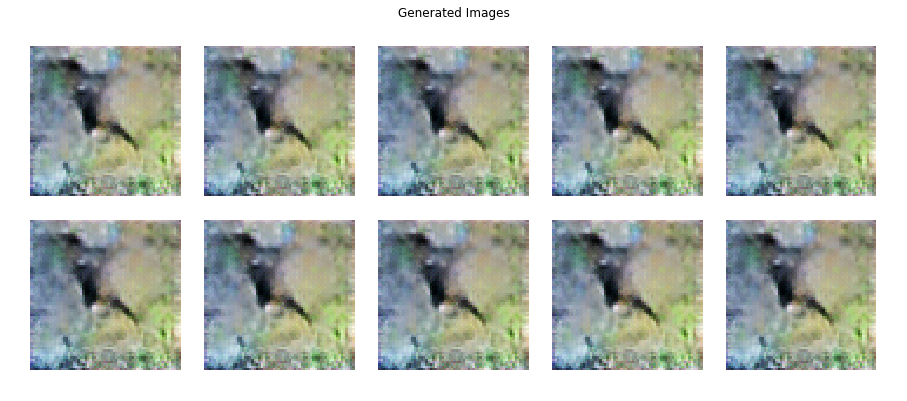

In [69]:
one_noise = torch.randn(
    1, nz
).to(device)

repeated_noise = one_noise.repeat(nl, 1)

diff_conds = encodeOneHot(
    torch.tensor(
        list(
            range(0, nl)
        )
    )
).to(device)

generated = netG(
    repeated_noise,
    diff_conds
).detach().cpu().view(-1, 3, 64, 64)


grid = torchvision.utils.make_grid(
    generated,
    padding=10,
    pad_value=1,
    normalize=True,
    nrow=5
)


plt.figure(figsize=(16, 12))
plt.axis("off")
plt.title("Generated Images")

plt.imshow(
    np.transpose(
        grid,
        (1,2,0)
    )
);